# 02 - Exploratory Data Analysis

## Objetivo
- Explorar distribuciones y relaciones clave del dataset procesado.
- Identificar patrones por distrito/subdistrito y posibles sesgos.
- Revisar densidades espaciales y missingness por zona.

## Flujo general
- Cargar `artifacts/processed_rent.*`.
- Graficar distribuciones de price, price_m2, surface_m2.
- Comparar medianas por zona y visualizar mapa de precios.
- Resumir missingness y correlaciones numericas.

## Inputs esperados
- `artifacts/processed_rent.csv.gz`

## Outputs/artefactos
- Figuras EDA (histogramas, barras por zona, mapas, correlaciones).


> **Nota:** Este EDA se restringe al conjunto de entrenamiento (train split) para evitar holdout snooping. Si no se encuentra el archivo de split, se usa el dataset completo con una advertencia.

In [1]:
from __future__ import annotations
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

SEED = 100432070
np.random.seed(SEED)

def get_repo_root() -> Path:
    """Return repo root by walking parents looking for .git or pyproject.toml."""
    current = Path.cwd().resolve()
    for parent in [current] + list(current.parents):
        if (parent / ".git").exists() or (parent / "pyproject.toml").exists():
            return parent
    return current

ROOT = get_repo_root()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from src.utils import plot_maps, spatial_group

# --- Cargar dataset procesado ---
processed_path = ROOT / "artifacts" / "processed_rent.parquet"
if processed_path.exists():
    rent_df = pd.read_parquet(processed_path)
else:
    rent_df = pd.read_csv(ROOT / "artifacts" / "processed_rent.csv.gz")

# Load split to restrict EDA to train set (avoid holdout snooping)
split_path = ROOT / "artifacts" / "splits" / "holdout_indices.npz"
if split_path.exists():
    _split = np.load(split_path)
    _train_idx = _split["train_idx"]
    rent_df = rent_df.loc[rent_df.index.isin(_train_idx)].copy()
    print(f"EDA restringido a train: {len(rent_df)} filas")
else:
    print("WARN: No se encontro split, usando dataset completo para EDA")

rent_df.head()

EDA restringido a train: 3419 filas


,web_id,url,title,type,price,deposit,private_owner,professional_name,floor_built,floor_area,...,district,subdistrict,postalcode,last_update,lat,lng,surface_m2,surface_is_built,price_m2,distance_center_km
13,95846546,https://www.idealista.com/en/inmueble/95846546/,Flat / apartment for rent in avenida de Concha...,Flat,2900.0,NaN,False,Diplomatic,177,NaN,...,Chamartín,El Viso,NaN,2025-10-26 00:00:00,40.451747,-3.683456,177.0,True,16.384181,4.250317
14,99323473,https://www.idealista.com/en/inmueble/99323473/,Flat / apartment for rent in Prosperidad,Flat,1300.0,NaN,False,Area Casa,82,81.0,...,Chamartín,Prosperidad,NaN,2025-10-27 00:00:00,40.444267,-3.672436,81.0,False,16.049383,4.046669
21,99166300,https://www.idealista.com/en/inmueble/99166300/,"Flat / apartment for rent in calle de Oruro, 4",Flat,1300.0,2.0,False,Properlia Servicios Inmobiliarios,82,65.0,...,Chamartín,Bernabéu-Hispanoamérica,28016.0,2025-10-25 00:00:00,40.455192,-3.679665,65.0,False,20.000000,4.732489
23,99130237,https://www.idealista.com/en/inmueble/99130237/,Flat / apartment for rent in pasaje de San Pedro,Flat,1050.0,NaN,False,Glomar,113,NaN,...,Chamartín,Prosperidad,28002.0,2025-10-10 00:00:00,40.445610,-3.662493,113.0,True,9.292035,4.741918
24,99071708,https://www.idealista.com/en/inmueble/99071708/,Flat / apartment for rent in Bernabéu-Hispanoa...,Flat,2300.0,3.0,False,JACK HOUSE PROPERTIES,120,NaN,...,Chamartín,Bernabéu-Hispanoamérica,28036.0,2025-10-21 00:00:00,40.453039,-3.688334,120.0,True,19.166667,4.236840


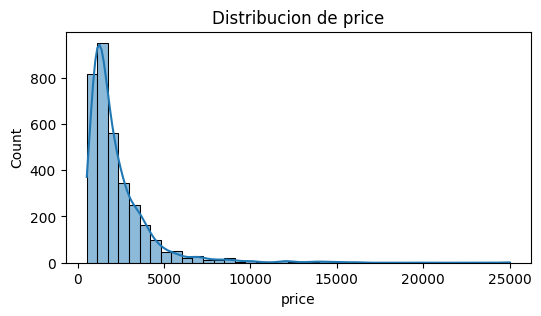

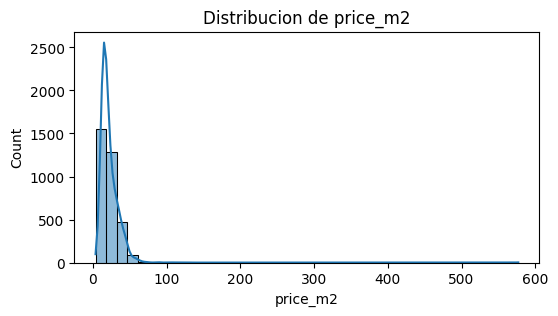

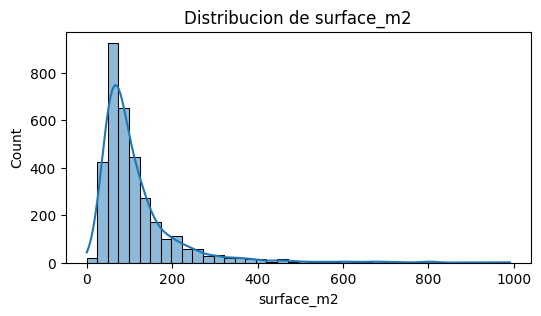

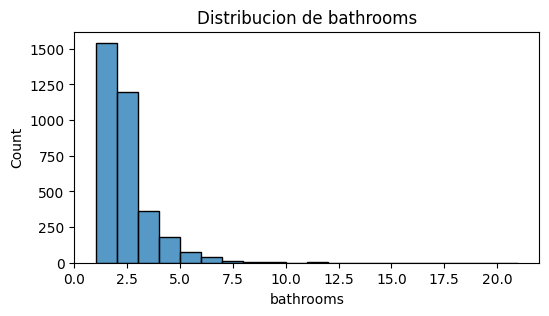

In [2]:
# =====================================================================
# Distribuciones de las variables principales
# =====================================================================
# Visualizamos histogramas con curva de densidad (KDE) para entender
# la forma de cada variable:
#   - price: precio mensual de alquiler (EUR). Esperamos sesgo a la derecha.
#   - price_m2: precio por metro cuadrado (EUR/m2). Normaliza por tamanio.
#   - surface_m2: superficie del inmueble en metros cuadrados.

for col in ["price", "price_m2", "surface_m2"]:
    if col in rent_df.columns:
        plt.figure(figsize=(6, 3))
        sns.histplot(rent_df[col].dropna(), bins=40, kde=True)
        plt.title(f"Distribucion de {col}")
        plt.show()

# =====================================================================
# Distribuciones de variables discretas (habitaciones, banos)
# =====================================================================
# Estas variables toman valores enteros (1, 2, 3...) asi que usamos
# histogramas con bins enteros para ver la frecuencia de cada valor.

for col in rent_df.columns:
    if col.lower() in ["rooms", "bathrooms", "habitaciones", "banos"]:
        plt.figure(figsize=(6, 3))
        sns.histplot(rent_df[col].dropna(), bins=range(int(rent_df[col].min()), int(rent_df[col].max()) + 2), kde=False)
        plt.title(f"Distribucion de {col}")
        plt.xlabel(col)
        plt.show()


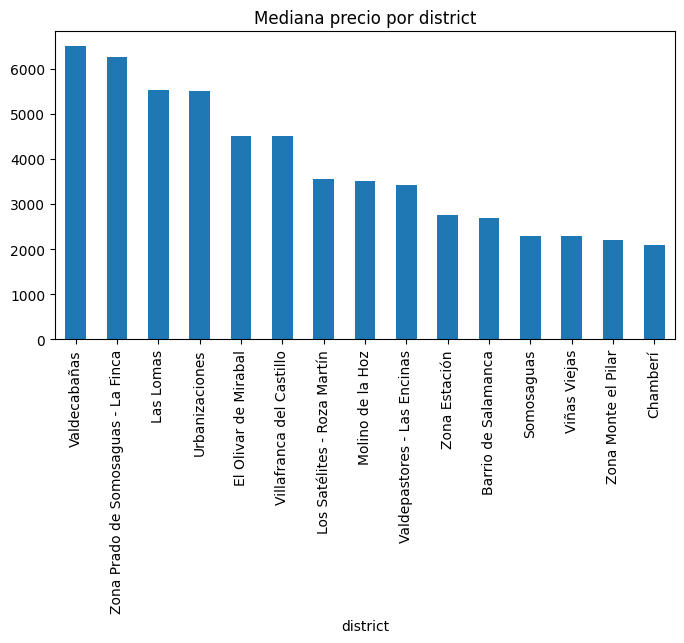

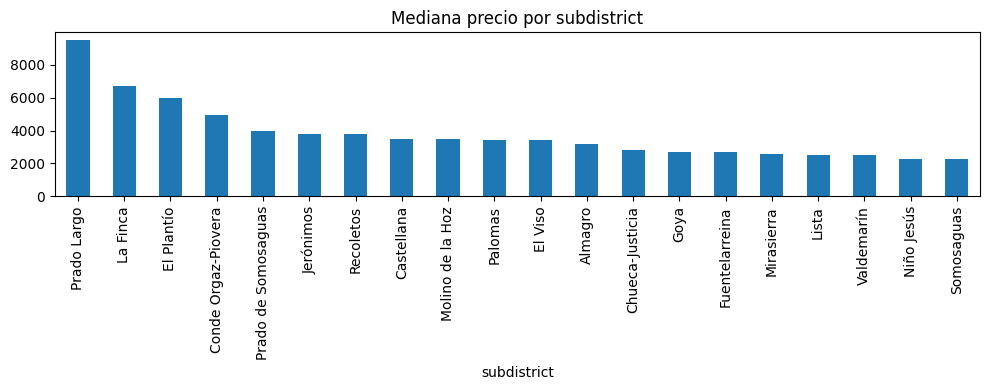

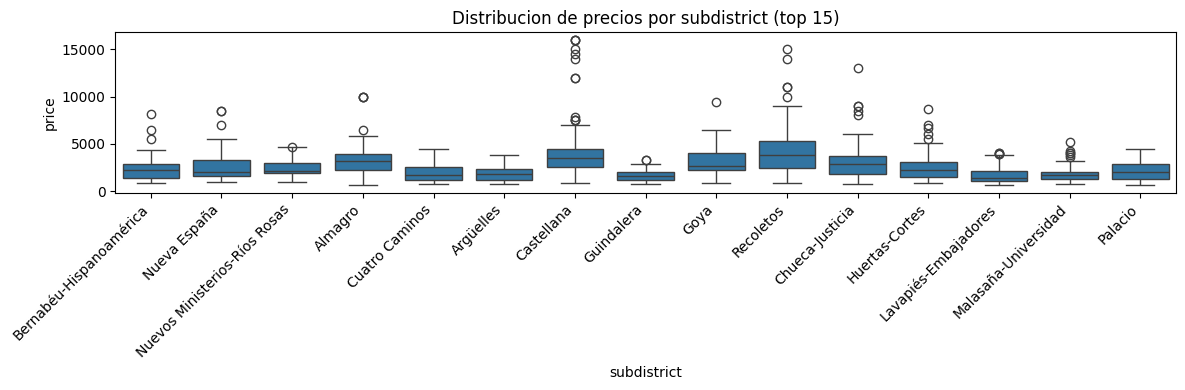

In [3]:
# =====================================================================
# Comparativa de precios por distrito (zona principal)
# =====================================================================
# Calculamos la mediana de precio por distrito y la mostramos como
# grafico de barras ordenado de mayor a menor. La mediana es mas
# robusta que la media ante valores atipicos (pisos de lujo).

cat_cols = [
    c for c in rent_df.columns
    if any(k in c.lower() for k in ["distrito", "barrio", "district", "subdistrict"])
]
if cat_cols and "price" in rent_df.columns:
    group_col = cat_cols[0]
    summary = rent_df.groupby(group_col)["price"].median().sort_values(ascending=False).head(15)
    summary.plot(kind="bar", figsize=(8, 4), title=f"Mediana precio por {group_col}")
    plt.show()

# =====================================================================
# Comparativa de precios por subdistrito/barrio
# =====================================================================
# Repetimos el analisis a nivel de barrio (subdivision mas fina del
# distrito). Esto revela variabilidad intra-distrito que el modelo
# deberia capturar con features de ubicacion.

subdistrict_candidates = [
    c for c in rent_df.columns
    if any(k in c.lower() for k in ["subdistrict", "subdistrito", "barrio", "neighbourhood", "neighborhood"])
]
if subdistrict_candidates and "price" in rent_df.columns:
    sub_col = subdistrict_candidates[0]
    if sub_col != group_col:
        # Barras de mediana por barrio (top 20)
        summary_sub = rent_df.groupby(sub_col)["price"].median().sort_values(ascending=False).head(20)
        summary_sub.plot(kind="bar", figsize=(10, 4), title=f"Mediana precio por {sub_col}")
        plt.tight_layout()
        plt.show()

        # Boxplots para ver la dispersion y outliers en cada barrio
        # (solo top 15 por numero de anuncios para que sea legible)
        top_sub = rent_df[sub_col].value_counts().head(15).index
        plt.figure(figsize=(12, 4))
        sns.boxplot(data=rent_df[rent_df[sub_col].isin(top_sub)], x=sub_col, y="price")
        plt.xticks(rotation=45, ha="right")
        plt.title(f"Distribucion de precios por {sub_col} (top 15)")
        plt.tight_layout()
        plt.show()


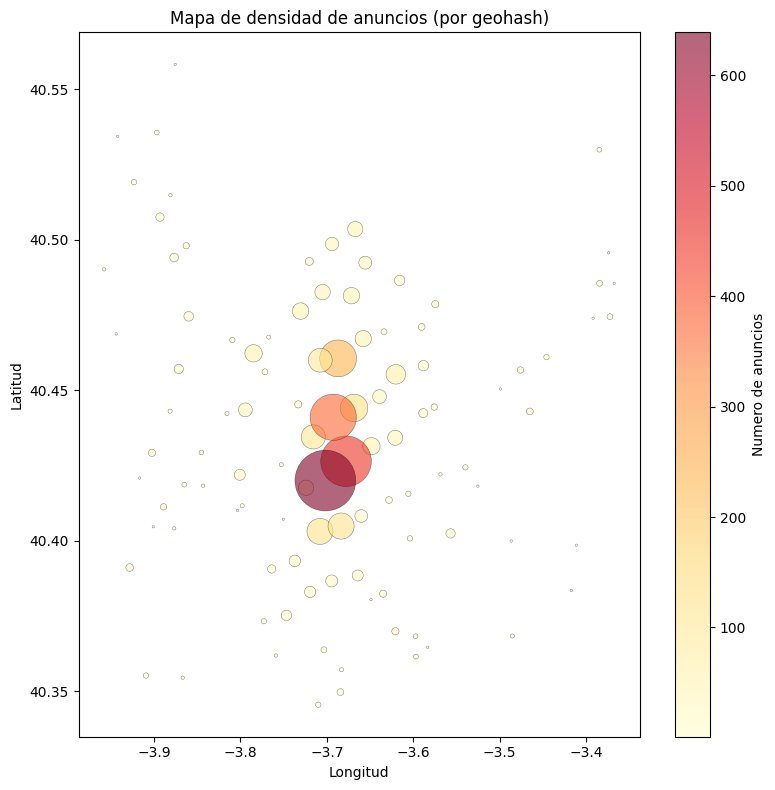

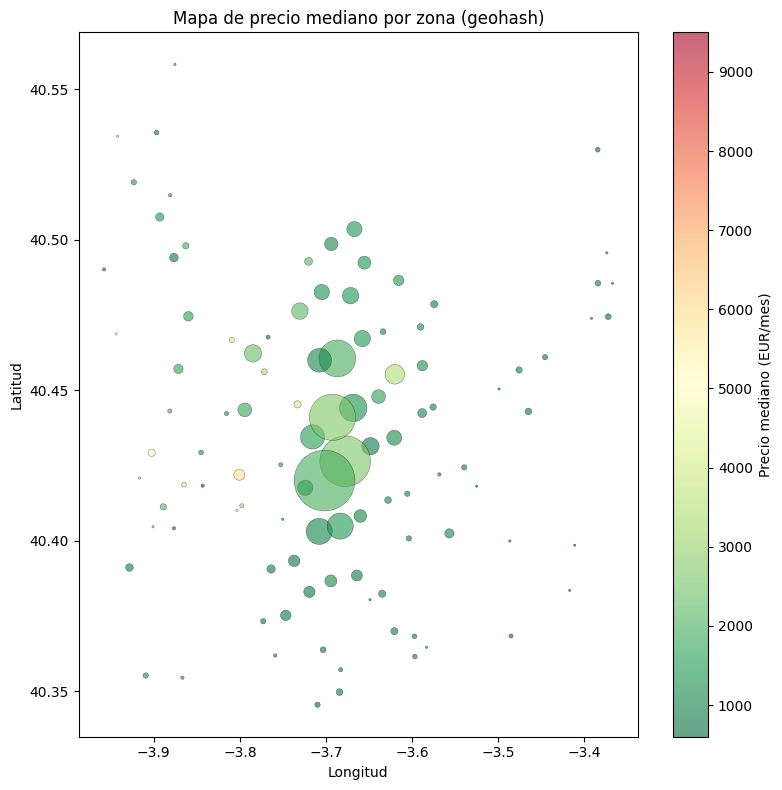

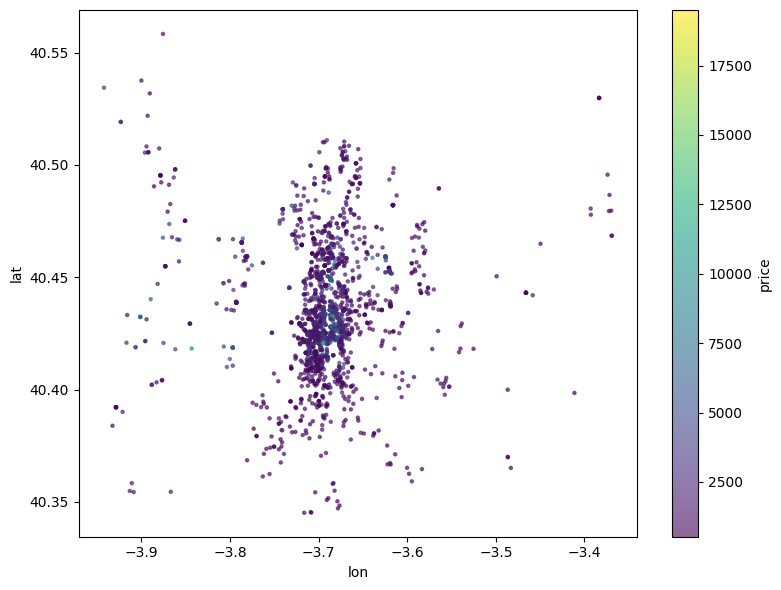

In [4]:
# =====================================================================
# Mapas de densidad y precio por zona geografica
# =====================================================================
# Usamos geohash de precision 6 para agrupar anuncios cercanos y crear
# dos mapas de burbujas:
#   1. Densidad: cuantos anuncios hay en cada zona (revela concentracion)
#   2. Precio mediano: cuanto cuestan los pisos en cada zona
# El tamanio de cada burbuja es proporcional al numero de anuncios.

lat_col = next((c for c in rent_df.columns if "lat" in c.lower()), None)
lon_col = next((c for c in rent_df.columns if "lon" in c.lower() or "lng" in c.lower()), None)

if lat_col and lon_col:
    # Agrupar anuncios en celdas geohash (cuadriculas geograficas)
    rent_df["geohash_6"] = spatial_group(rent_df, lat_col, lon_col, precision=6)
    geo_summary = rent_df.groupby("geohash_6").agg(
        count=("geohash_6", "size"),
        price_median=("price", "median"),
        lat_mean=(lat_col, "mean"),
        lng_mean=(lon_col, "mean"),
    ).reset_index()

    # --- Mapa 1: Densidad de anuncios ---
    # Colores calidos = mas anuncios (centro de Madrid tendra mas)
    plt.figure(figsize=(8, 8))
    plt.scatter(
        geo_summary["lng_mean"], geo_summary["lat_mean"],
        s=geo_summary["count"] * 3,
        c=geo_summary["count"],
        cmap="YlOrRd", alpha=0.6, edgecolors="k", linewidths=0.3,
    )
    plt.colorbar(label="Numero de anuncios")
    plt.title("Mapa de densidad de anuncios (por geohash)")
    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    plt.tight_layout()
    plt.show()

    # --- Mapa 2: Precio mediano por zona ---
    # Colores rojos = zona mas cara, verdes = zona mas barata
    plt.figure(figsize=(8, 8))
    plt.scatter(
        geo_summary["lng_mean"], geo_summary["lat_mean"],
        s=geo_summary["count"] * 3,
        c=geo_summary["price_median"],
        cmap="RdYlGn_r", alpha=0.6, edgecolors="k", linewidths=0.3,
    )
    plt.colorbar(label="Precio mediano (EUR/mes)")
    plt.title("Mapa de precio mediano por zona (geohash)")
    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    plt.tight_layout()
    plt.show()

    # --- Mapa interactivo con folium (muestra de puntos individuales) ---
    plot_maps(rent_df.sample(min(2000, len(rent_df))), lat_col, lon_col, "price")


district
Reyes Católicos                0.141026
Coslada Pueblo                 0.128205
El Bosque                      0.120513
Ciudad 70                      0.115385
Los Satélites - Roza Martín    0.115385
El Puerto                      0.102564
Parque Boadilla                0.102564
Pinar de las Rozas             0.102564
Cerro Alarcón                  0.102564
Viñas Viejas                   0.102564
dtype: float64


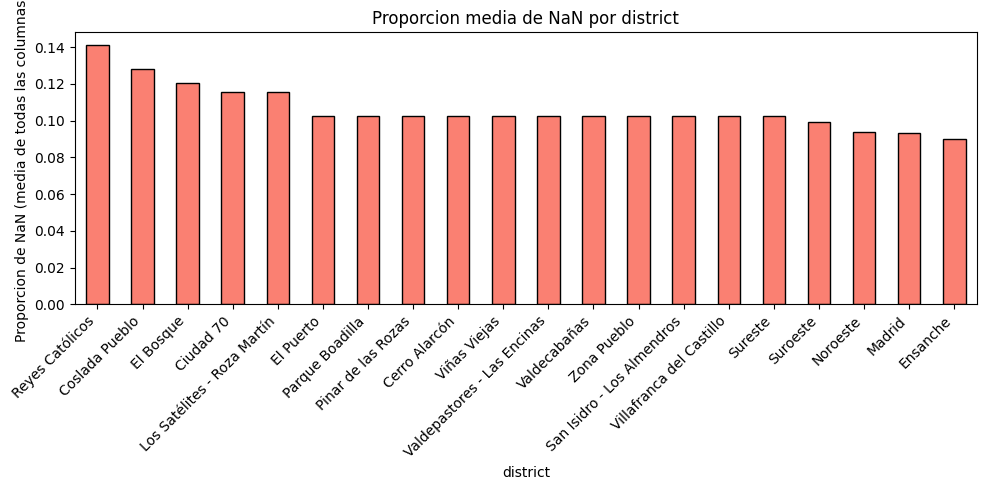

In [5]:
# =====================================================================
# Analisis de datos faltantes (missingness) por zona
# =====================================================================
# Es importante saber si los valores nulos (NaN) se distribuyen
# uniformemente o si ciertas zonas tienen peor calidad de datos.
# Un alto porcentaje de NaN en una zona puede indicar anuncios
# incompletos o zonas con menos informacion disponible.

zone_cols = [
    c for c in rent_df.columns
    if any(k in c.lower() for k in ["distrito", "barrio", "district", "subdistrict"])
]
if zone_cols:
    zone_col = zone_cols[0]
    # Calcular la proporcion media de NaN por zona (promedio de todas las columnas)
    missing_summary = rent_df.isna().groupby(rent_df[zone_col]).mean().mean(axis=1)
    missing_summary = missing_summary.sort_values(ascending=False)
    print(missing_summary.head(10))

    # Grafico de barras con las zonas mas afectadas por datos faltantes
    plt.figure(figsize=(10, 5))
    missing_summary.head(20).plot(kind="bar", color="salmon", edgecolor="k")
    plt.title(f"Proporcion media de NaN por {zone_col}")
    plt.ylabel("Proporcion de NaN (media de todas las columnas)")
    plt.xlabel(zone_col)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


**Outputs esperados**
- Histogramas por variable numerica (price, price_m2, surface_m2).
- Barras de mediana de precio por zona.
- Mapa de puntos con precios (si hay lat/lon).
- Tabla con missingness promedio por zona.


### Visualizaciones adicionales
- Mapa de correlaciones para detectar colinealidad.
- Boxplots por zona (top 12) para detectar dispersion y outliers.


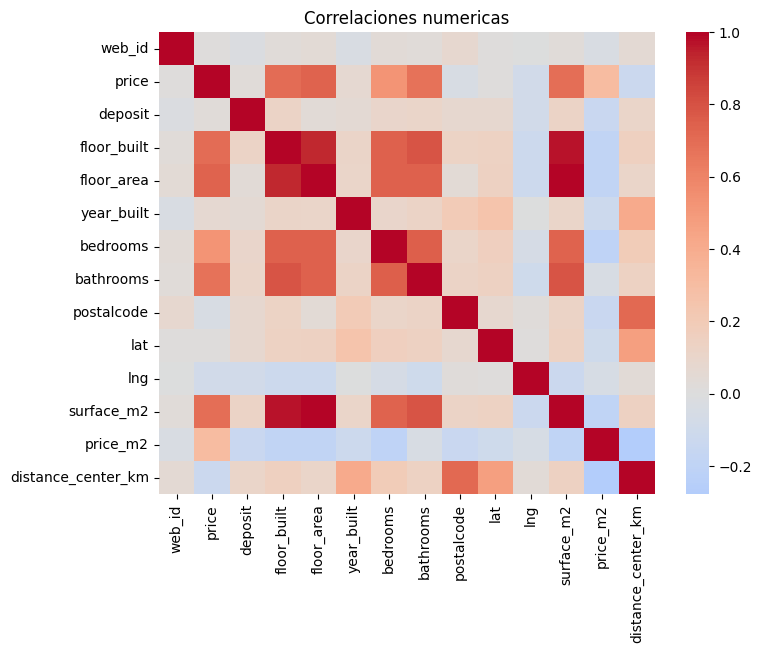

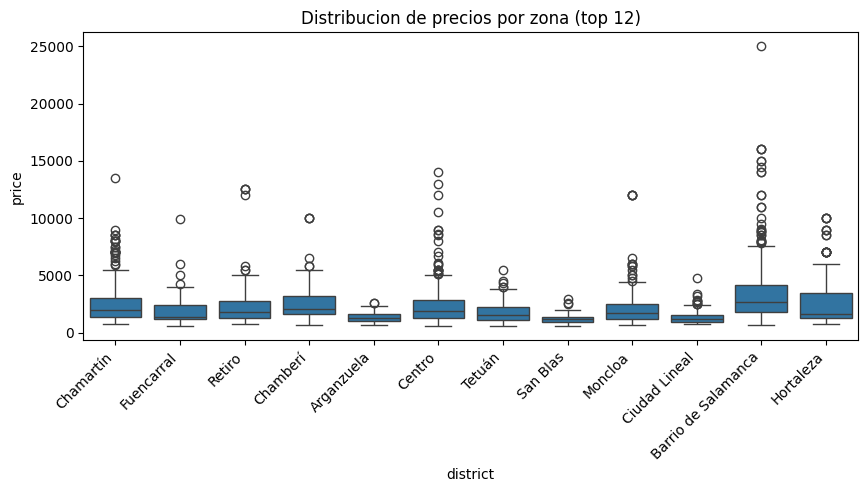

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# =====================================================================
# Mapa de correlaciones numericas
# =====================================================================
# Un heatmap de correlaciones permite detectar:
#   - Variables muy correlacionadas entre si (colinealidad), que podrian
#     causar inestabilidad en modelos lineales.
#   - Variables con alta correlacion con el precio (buenas predictoras).
# Valores cercanos a +1/-1 indican relacion fuerte; cercanos a 0, debil.

numeric = rent_df.select_dtypes(include=["number"])
if not numeric.empty:
    plt.figure(figsize=(8, 6))
    sns.heatmap(numeric.corr(), cmap="coolwarm", center=0)
    plt.title("Correlaciones numericas")
    plt.show()

# =====================================================================
# Boxplots de precio por zona (top 12 distritos)
# =====================================================================
# Los boxplots muestran la mediana (linea central), los cuartiles
# (caja) y los valores atipicos (puntos fuera de los bigotes).
# Permiten comparar rapidamente la dispersion de precios entre zonas.

if cat_cols and "price" in rent_df.columns:
    top_zones = rent_df[group_col].value_counts().head(12).index
    plt.figure(figsize=(10, 4))
    sns.boxplot(data=rent_df[rent_df[group_col].isin(top_zones)], x=group_col, y="price")
    plt.xticks(rotation=45, ha="right")
    plt.title("Distribucion de precios por zona (top 12)")
    plt.show()


## Conclusiones del Notebook 02 — Analisis Exploratorio (EDA)

### ¿Que hemos descubierto?

El EDA nos ha dado una **radiografia completa del mercado de alquiler en Madrid**, revelando patrones que el modelo debera capturar para predecir bien.

### Hallazgos principales

| Patron descubierto | Detalle | ¿Por que importa para el modelo? |
|---------------------|---------|----------------------------------|
| **Distribucion de precios** | Sesgada a la derecha, mediana ~1.450 EUR/mes | La mayoria de pisos cuestan entre 800 y 2.500 EUR, pero hay una cola larga de pisos de lujo (>5.000 EUR). Esto justifica usar transformacion logaritmica en NB03 y MAE (en vez de MSE) como metrica |
| **Distritos mas caros** | Salamanca, Chamberi, Centro y Chamartin lideran | La ubicacion es el factor dominante en el precio. El modelo necesita features geograficas potentes |
| **Variabilidad intra-distrito** | Dentro de un mismo distrito, los precios varian mucho entre barrios | No basta con saber el distrito — el modelo necesita granularidad a nivel de barrio o coordenadas exactas |
| **Concentracion espacial** | El centro de Madrid acumula la mayor densidad de anuncios | Hay mas datos para entrenar en zonas centricas, pero menos en la periferia. El modelo podria ser menos preciso en zonas con pocos datos |
| **Missingness por zona** | Algunas zonas perifericas tienen hasta 14% de NaN (media de todas las columnas) | Los anuncios de zonas alejadas tienden a estar mas incompletos. El imputer debe ser robusto |
| **Correlaciones** | `surface_m2` y `floor_built` muy correlacionadas (esperado); `distance_center_km` negativamente correlacionada con `price` | Confirma la intuicion: pisos mas grandes y mas centricos cuestan mas |

### ¿Que implica para los siguientes pasos?

- **Features geograficas** (distancia al centro, geohash, densidad local) seran cruciales — el EDA confirma que la ubicacion domina los precios.
- **Transformaciones log** son necesarias para price y surface_m2 (distribuciones muy sesgadas).
- **El modelo debe manejar bien zonas con pocos datos** — la periferia tiene menos anuncios y mas missingness.
- **Los boxplots por distrito/barrio** muestran outliers reales (pisos de lujo), no errores de datos.

> **Nota importante**: Todo el EDA se ha hecho **solo con el conjunto de train** (3.419 filas) para evitar contaminar el holdout con informacion que podria sesgar nuestras decisiones.

### Siguiente notebook
→ **NB03 (Features Core)**: Crear variables como distancia al centro, densidad local OOF y transformaciones logaritmicas.